In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW  # <--- PERUBAHAN DI SINI
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

d:\conda_envs\nlp_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ===============================
# PATH DATASET
# ===============================
DATASET_PATH = r"D:\DLClassifyRacist\dataset\dataset_processed.csv"

# ===============================
# LOAD DATASET
# ===============================
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(
        f"❌ File dataset tidak ditemukan di: {DATASET_PATH}"
    )

df = pd.read_csv(DATASET_PATH)

# ===============================
# CLEANING
# ===============================
if "cleaned_text" not in df.columns:
    raise ValueError(
        f"❌ Kolom 'cleaned_text' tidak ditemukan. Kolom tersedia: {df.columns.tolist()}"
    )

df.dropna(subset=["cleaned_text"], inplace=True)

# ===============================
# INFO DATASET
# ===============================
print("✅ Dataset berhasil dimuat!")
print("Jumlah data:", len(df))
display(df.head())

✅ Dataset berhasil dimuat!
Jumlah data: 3240


,id,cleaned_text,label,label_numeric
0,1,ci intan panggil cina,hate_speech,0
1,2,nampak lelah keringat kucur deras sampahhhhh,hate_speech,1
2,3,si aki herkules nantangin sunda hatihati ah le...,hate_speech,1
3,4,diam ah trump,not_hate_speech,0
4,5,kasihan yatim piatu janda hak terima zakat sah...,not_hate_speech,0


In [3]:
# Tentukan model yang akan digunakan
MODEL_NAME = 'indobenchmark/indobert-base-p2'

# Muat tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Mengambil satu kalimat contoh dari data yang sudah dibersihkan
contoh_teks = df['cleaned_text'].iloc[0]
# Memproses kalimat agar bisa dibaca oleh model kecerdasan buatan
encoding = tokenizer.encode_plus(
    contoh_teks,  # Teks yang akan ditokenisasi
    add_special_tokens=True,  # Menambahkan simbol khusus di awal dan akhir kalimat agar model bisa memahami strukturnya
    max_length=128,  # Membatasi panjang kalimat agar maksimal 128 kata (token)
    padding='max_length', # Jika kalimatnya terlalu pendek, akan ditambah kata kosong agar panjangnya sama
    truncation=True,  # Jika kalimatnya terlalu panjang, sisanya akan dibuang agar tidak melebihi batas
    return_attention_mask=True, # Memberi tanda pada bagian mana yang merupakan kalimat asli dan mana yang hanya tambahan
    return_tensors='pt' # Mengubah hasil pemrosesan menjadi format khusus yang bisa dibaca oleh mesin (PyTorch) 
)

print(f"Teks Asli: {contoh_teks}")
print(f"Input IDs: {encoding['input_ids']}")
print(f"Attention Mask: {encoding['attention_mask']}")

d:\conda_envs\nlp_project\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\andik\.cache\huggingface\hub\models--indobenchmark--indobert-base-p2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Teks Asli: ci intan panggil cina
Input IDs: tensor([[    2,  4745, 14589, 11117,  4385,     3,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        

In [4]:
# Pisahkan fitur (X) dan label (y)
X = df['cleaned_text'].values
y = df['label_numeric'].values

# Bagi data menjadi 80% train+validation dan 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Bagi 90% data sisanya menjadi 80% train dan 10% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.11, random_state=42, stratify=y_train_val # 0.11 dari 0.9 akan menghasilkan ~0.1 dari total
)

print(f"Jumlah data latih: {len(X_train)}")
print(f"Jumlah data validasi: {len(X_val)}")
print(f"Jumlah data uji: {len(X_test)}")

Jumlah data latih: 2595
Jumlah data validasi: 321
Jumlah data uji: 324


In [5]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item_idx):
        text = str(self.texts[item_idx])
        label = self.labels[item_idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Buat instance Dataset untuk masing-masing set
train_dataset = HateSpeechDataset(X_train, y_train, tokenizer)
val_dataset = HateSpeechDataset(X_val, y_val, tokenizer)
test_dataset = HateSpeechDataset(X_test, y_test, tokenizer)

# Buat DataLoader
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [6]:
# Cek ketersediaan GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# Muat model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

# Penanganan Imbalance dengan Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Definisikan loss function dengan bobot
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# Definisikan optimizer
optimizer = AdamW(model.parameters(), lr=2e-5) 

Menggunakan device: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [7]:
# =========================================
# KONFIGURASI EPOCH & PATH MODEL
# =========================================

# Kita akan melatih model sebanyak 3 kali pengulangan penuh (epoch)
NUM_EPOCHS = 3

# Variabel untuk menyimpan skor F1 terbaik
best_val_f1 = 0

# Buat folder penyimpanan model
MODEL_DIR = "./model_indobertbase"
os.makedirs(MODEL_DIR, exist_ok=True)

# Lokasi untuk menyimpan model terbaik
model_save_path = os.path.join(
    MODEL_DIR, "model_terbaik_indobertbase.bin"
)

# =========================================
# TRAINING LOOP
# =========================================
for epoch in range(NUM_EPOCHS):

    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")

    # Mode training
    model.train()

    # Total loss training
    total_loss_train = 0

    # Loop per batch
    for batch in train_loader:

        # Pindahkan data ke device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Reset gradien
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Ambil loss
        loss = outputs.loss
        total_loss_train += loss.item()

        # Backpropagation
        loss.backward()

        # Update parameter
        optimizer.step()

    # Rata-rata loss training
    avg_train_loss = total_loss_train / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")


===== Epoch 1/3 =====
Train Loss: 0.3919

===== Epoch 2/3 =====
Train Loss: 0.1424

===== Epoch 3/3 =====
Train Loss: 0.0472


In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score
import os

# ============================
# EVALUATION
# ============================
model.eval()
val_preds, val_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(outputs.logits, dim=1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# ============================
# METRICS
# ============================
avg_train_loss = total_loss_train / len(train_loader)

val_f1 = f1_score(val_labels, val_preds, average="weighted")
val_precision = precision_score(val_labels, val_preds, average="weighted")
val_recall = recall_score(val_labels, val_preds, average="weighted")

print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
print(f"Training Loss: {avg_train_loss:.4f}")
print(
    f"Validation F1: {val_f1:.4f} | "
    f"Precision: {val_precision:.4f} | "
    f"Recall: {val_recall:.4f}"
)

# ============================
# SAVE BEST MODEL (FINAL FIX)
# ============================
if val_f1 > best_val_f1:
    best_val_f1 = val_f1

    MODEL_DIR = r"D:\DLClassifyRacist\model_indobertbase"
    os.makedirs(MODEL_DIR, exist_ok=True)

    # ⬇⬇⬇ INI YANG BENAR
    model.save_pretrained(MODEL_DIR)
    tokenizer.save_pretrained(MODEL_DIR)

    print(f"✅ Model & tokenizer TERBAIK disimpan di {MODEL_DIR}")

print("-" * 50)

Epoch 3/3
Training Loss: 0.0472
Validation F1: 0.9152 | Precision: 0.9167 | Recall: 0.9159
✅ Model & tokenizer TERBAIK disimpan di D:\DLClassifyRacist\model_indobertbase
--------------------------------------------------


In [10]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

# ======================================
# EVALUATION
# ======================================
model.eval()

val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(outputs.logits, dim=1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# ======================================
# METRICS
# ======================================
avg_train_loss = total_loss_train / len(train_loader)

val_f1 = f1_score(val_labels, val_preds, average='weighted')
val_precision = precision_score(val_labels, val_preds, average='weighted')
val_recall = recall_score(val_labels, val_preds, average='weighted')

print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
print(f"Training Loss: {avg_train_loss:.4f}")
print(
    f"Validation F1: {val_f1:.4f} | "
    f"Precision: {val_precision:.4f} | "
    f"Recall: {val_recall:.4f}"
)

# ======================================
# CLASSIFICATION REPORT (INI YANG KAMU MAU)
# ======================================
print("\nClassification Report:")
print(
    classification_report(
        val_labels,
        val_preds,
        target_names=["Non-Racist", "Racist"],
        digits=4
    )
)

# ======================================
# SAVE BEST MODEL
# ======================================
if val_f1 > best_val_f1:
    best_val_f1 = val_f1
    torch.save(model.state_dict(), model_save_path)
    print(f"✅ Model terbaik disimpan di {model_save_path}")

print("-" * 50)

Epoch 3/3
Training Loss: 0.0472
Validation F1: 0.9152 | Precision: 0.9167 | Recall: 0.9159

Classification Report:
              precision    recall  f1-score   support

  Non-Racist     0.9069    0.9585    0.9320       193
      Racist     0.9316    0.8516    0.8898       128

    accuracy                         0.9159       321
   macro avg     0.9192    0.9051    0.9109       321
weighted avg     0.9167    0.9159    0.9152       321

--------------------------------------------------


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# ==========================================
# 1. AMBIL PREDIKSI & PROBABILITAS
# ==========================================
model.eval()

y_true = []
y_pred = []
y_probs = [] # Kita butuh ini untuk ROC-AUC

print("Sedang memproses data uji...")

with torch.no_grad():
    for batch in test_loader: # Gunakan test_loader untuk evaluasi akhir
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Ambil Logits
        logits = outputs.logits

        # Ubah logits menjadi probabilitas menggunakan Softmax
        probs = F.softmax(logits, dim=1)

        # Ambil prediksi kelas (0 atau 1)
        preds = torch.argmax(logits, dim=1)

        # Simpan hasil
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy()) # Ambil probabilitas kelas positif (Racist/1)

print("✅ Selesai mengambil prediksi.")

Sedang memproses data uji...
✅ Selesai mengambil prediksi.


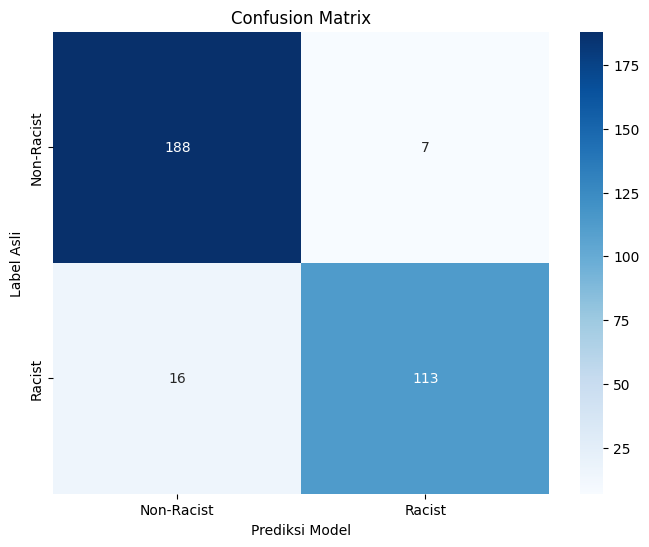

In [12]:
# ==========================================
# 2. PLOT CONFUSION MATRIX
# ==========================================
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Label Asli')
    plt.title('Confusion Matrix')
    plt.show()

# Panggil fungsi plot
# Sesuaikan label dengan dataset Anda (0=Non-Racist, 1=Racist)
plot_confusion_matrix(y_true, y_pred, labels=['Non-Racist', 'Racist'])

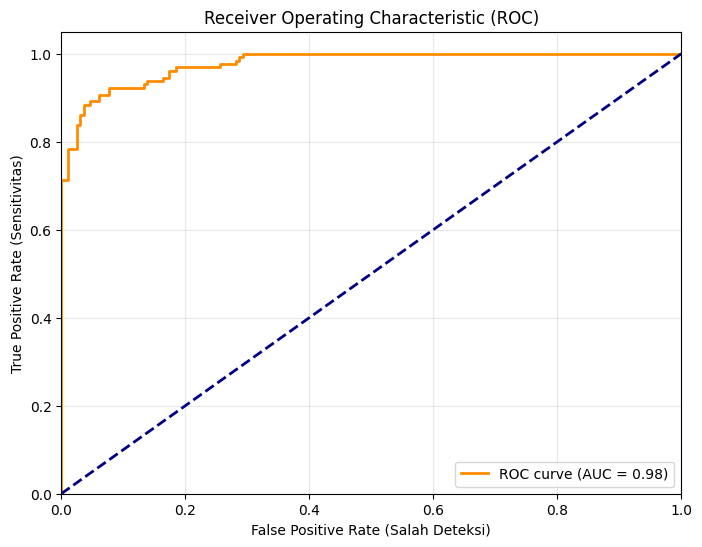

Nilai AUC Score: 0.9777


In [13]:
# ==========================================
# 3. PLOT ROC CURVE & AUC
# ==========================================
def plot_roc_curve(y_true, y_probs):
    # Hitung False Positive Rate (FPR) dan True Positive Rate (TPR)
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Garis acak (tebakan 50:50)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (Salah Deteksi)')
    plt.ylabel('True Positive Rate (Sensitivitas)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Nilai AUC Score: {roc_auc:.4f}")

# Panggil fungsi plot
plot_roc_curve(y_true, y_probs)